In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
pip install fidle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.__version__

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
import fidle

In [28]:
train = pd.read_csv('/kaggle/input/mydata/df_normalized_with_outlier.csv')
train = train.set_index('Datetime')

In [30]:
import random
def convert2matrix(data_arr, past, future, shuffle=False):
    X, Y = [], []
    size = len(data_arr)
    for i in range(size - future - past + 1):
        d = i + past
        y_ind = i + past + future - 1
        X.append(data_arr.iloc[i:d, 0:8])
        Y.append(data_arr.iloc[y_ind, -3:])
    if shuffle:
        c = list(zip(X, Y))
        random.shuffle(c)
        X, Y = zip(*c)
    return np.array(X), np.array(Y)

In [31]:
past, future = (1, 0)
X_train, y_train = convert2matrix(train, past, future, shuffle=True)

In [37]:
y_train.shape

(41932, 3)

In [46]:
#features = ['Datetime' ,'Temperature' ,'Humidity' ,'WindSpeed' ,'GeneralDiffuseFlows','DiffuseFlows']
def create_model_lstm_multi():
    inputs = keras.layers.Input(shape = (1,8))
    lstm_out_1 = keras.layers.LSTM(64, return_sequences=True, activation="relu")(inputs)
    lstm_out_2 = keras.layers.LSTM(256, return_sequences=False, activation="relu")(lstm_out_1)
    outputs = layers.Dense(3)(lstm_out_2)
    model = keras.Model(inputs=inputs, outputs=outputs, name='lstm_multivariate')

   
    model.compile(optimizer= 'adam', loss="mse")
    model.summary()
    path_checkpoint = "model_checkpoint.h5"
    #es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=path_checkpoint,
        verbose=0,
        save_weights_only=True,
        save_best_only=True)
    return model, modelckpt_callback 

In [45]:
model_lstm_multi, modelckpt_callback = create_model_lstm_multi()

ValueError: Input 0 of layer "lstm_8" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 256)

In [38]:
history = model_lstm_multi.fit(X_train, y_train,
                    epochs=100,validation_split=0.2, shuffle=True,
                    batch_size = 50, callbacks=[es_callback, modelckpt_callback],
                    verbose = 1)

Epoch 1/100
671/671 [==============================] - 10s 10ms/step - loss: 217885408.0000 - val_loss: 55092348.0000
Epoch 2/100
671/671 [==============================] - 6s 9ms/step - loss: 52910160.0000 - val_loss: 51340204.0000
Epoch 3/100
671/671 [==============================] - 7s 10ms/step - loss: 48997424.0000 - val_loss: 46903608.0000
Epoch 4/100
671/671 [==============================] - 6s 9ms/step - loss: 43650240.0000 - val_loss: 40295016.0000
Epoch 5/100
671/671 [==============================] - 6s 9ms/step - loss: 35225396.0000 - val_loss: 29765894.0000
Epoch 6/100
671/671 [==============================] - 6s 9ms/step - loss: 24523814.0000 - val_loss: 20760292.0000
Epoch 7/100
671/671 [==============================] - 6s 9ms/step - loss: 19926352.0000 - val_loss: 19597514.0000
Epoch 8/100
671/671 [==============================] - 6s 10ms/step - loss: 19562344.0000 - val_loss: 19337740.0000
Epoch 9/100
671/671 [==============================] - 6s 9ms/step - loss: 

In [54]:
X_train1.shape

(41932, 1, 8)

In [55]:
X_test.shape

(41932, 1, 8)

In [40]:
X_train1, y_train1 = convert2matrix(train, past, future)
def show_result_model(model , col):
    model = model
    y_pred = model.predict(X_train1)[:,col]
    y_target = y_train1[:, col] 
    diff = y_pred - y_target
    print('max deviation: ', np.abs(y_pred - y_target).max())
    print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
    print('MAE: ', np.abs(y_pred - y_target).mean())
    
    i = col+1
    load_target = 'PowerConsumption_Zone%i' % i

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 5))

    train.plot(y=load_target, ax=ax1)
    
    ax1.plot(train.index[0:], y_pred)
    ax1.legend(['True {0}'.format(load_target), 'Predictions {0}'.format(load_target)])
    ax2.plot(train.index[-24*5:],y_target[-24*5:])
    index_cor = train.index[0:]
    ax2.plot(index_cor[-24*5:],y_pred[-24*5:])
    #ax2.grid(True)
    ax2.legend(['Zoom True {0}'.format(load_target), 'Zoom Predictions {0}'.format(load_target)])
    plt.show()

1311/1311 [==============================] - 4s 3ms/step
max deviation:  17804.32865
RMSE:  2026.2362123268247
MAE:  1476.6482679295348


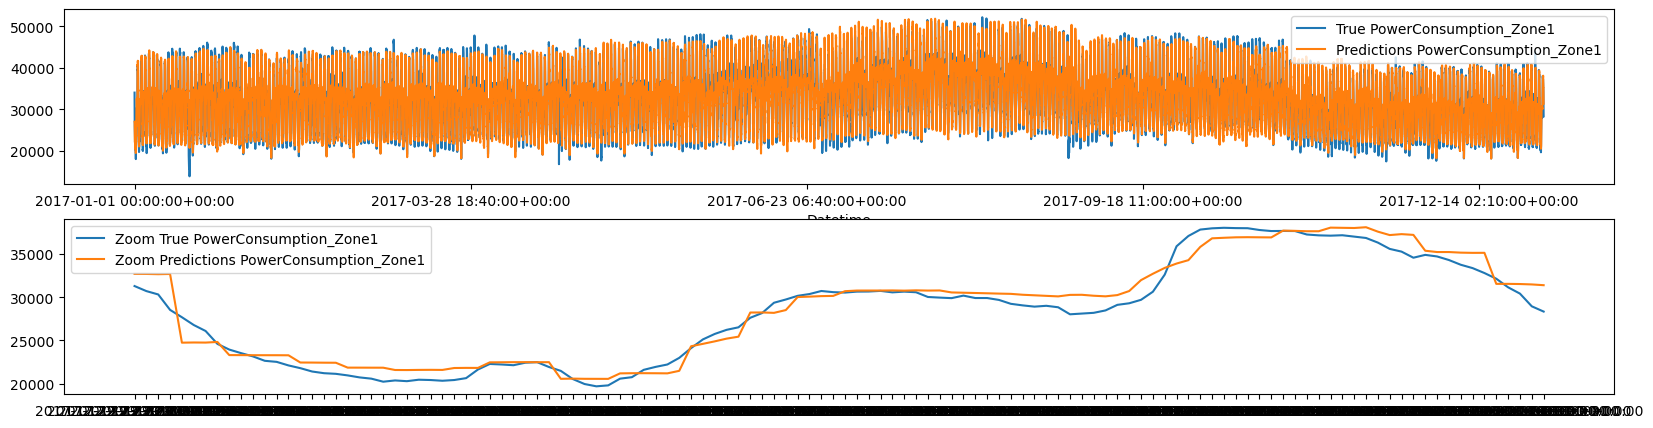

In [41]:
show_result_model(model_lstm_multi ,0)

1311/1311 [==============================] - 5s 4ms/step
max deviation:  9917.117680625
RMSE:  1568.5481317082788
MAE:  1173.5267734583135


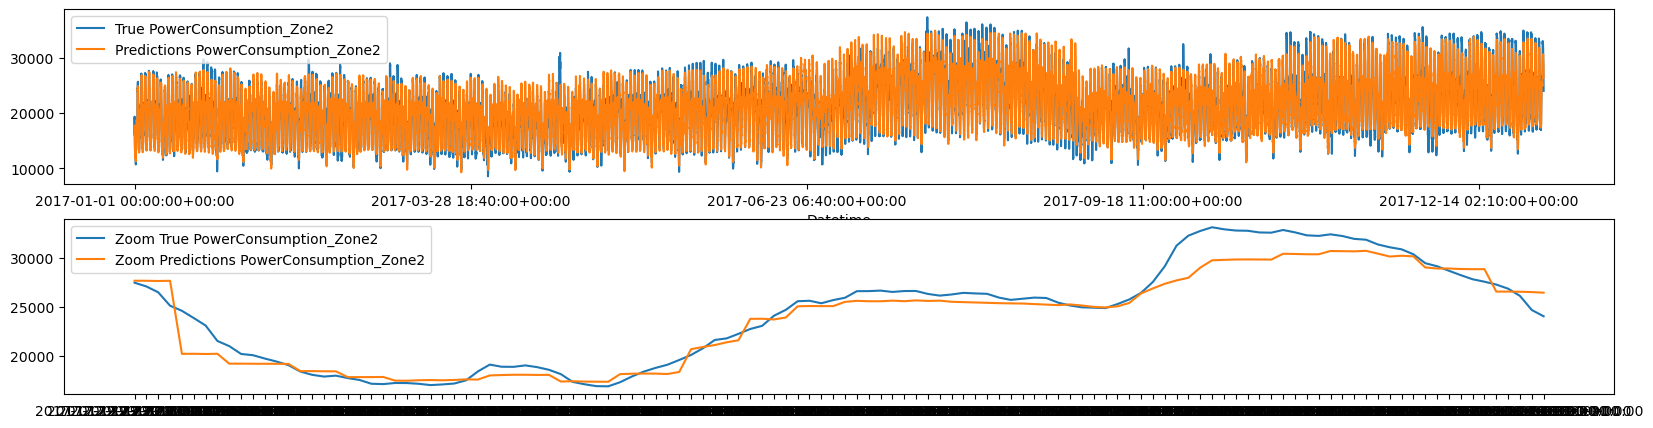

In [42]:
show_result_model(model_lstm_multi ,1)

1311/1311 [==============================] - 4s 3ms/step
max deviation:  11230.666868125001
RMSE:  1700.3595990538654
MAE:  1215.0240621131265


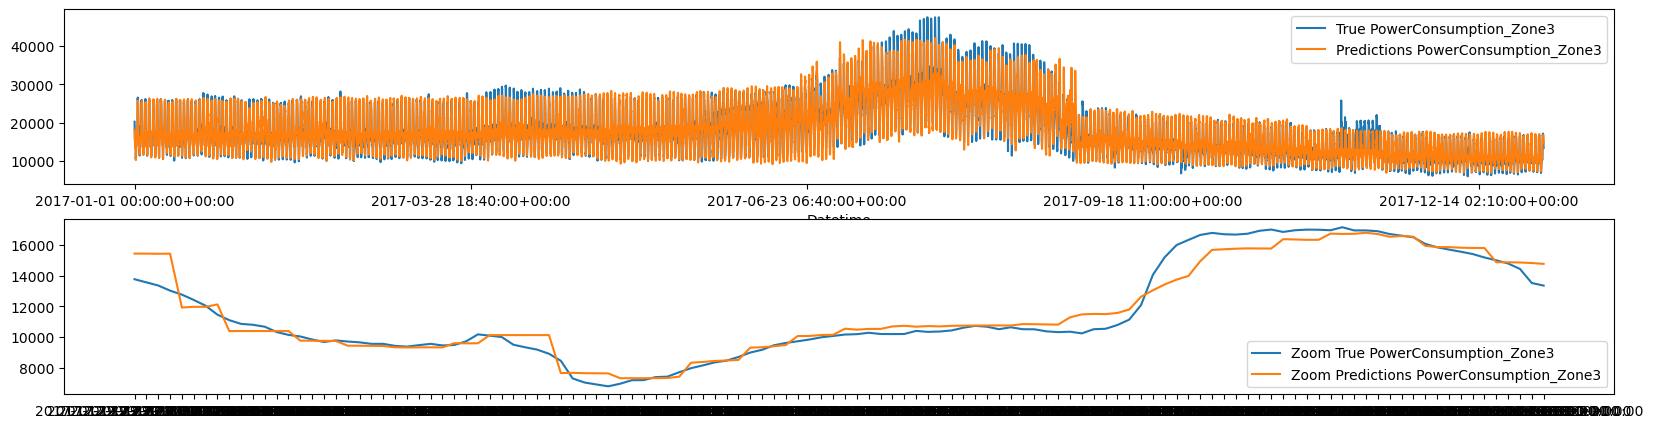

In [43]:
show_result_model(model_lstm_multi ,2)

In [62]:
test = pd.read_csv('/kaggle/input/mydata/df_normalized_test_with_outlier (1).csv')
test = test.set_index('Datetime')

In [64]:
def convert2matrix_test(data_arr, past, future):
    X  = []
    size = len(data_arr)
    for i in range(size - future - past + 1):
        d = i + past
        y_ind = i + past + future - 1
        X.append(data_arr.iloc[i:d, 0:8])
   
    return np.array(X)

In [65]:
past, future = (1, 0)
X_test = convert2matrix_test(test, past, future)

In [66]:
X_test.shape

(10483, 1, 8)

In [67]:
y_pred = model_lstm_multi.predict(X_test)

328/328 [==============================] - 1s 4ms/step


In [68]:
Sample = pd.read_csv('/kaggle/input/sample/sample_data (1).csv')

In [70]:
df = pd.DataFrame(y_pred, columns=['predicted_Zone1','predicted_Zone2','predicted_Zone3'], index=test.index)
df = df.reset_index(drop=False)
df['Datetime'] = Sample['Datetime']

In [72]:
df.to_csv('/kaggle/working/sample.csv', index=False)

# outre model

In [73]:
X_train.shape

(41932, 1, 8)

In [74]:
X_train = X_train.reshape(41932, 8)
y_train = y_train.reshape(41932, 3)

In [97]:
def create_model_dense(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(512, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(8, activation='relu', name='Dense_n3'))
    model.add(keras.layers.Dense(3, name='Output'))
  
    model.compile(optimizer = 'adam',
                    loss      = 'mse',
                    metrics   = ['mae', 'mse'] 
                 )
    model.summary()

    #es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=8)
    
    return model,es_callback

In [98]:
model, es_callback = create_model_dense(shape=8)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                576       
                                                                 
 Dense_n2 (Dense)            (None, 512)               33280     
                                                                 
 Dense_n3 (Dense)            (None, 8)                 4104      
                                                                 
 Output (Dense)              (None, 3)                 27        
                                                                 
Total params: 37,987
Trainable params: 37,987
Non-trainable params: 0
_________________________________________________________________


In [105]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.2, shuffle=True, batch_size = 10, verbose =1)

Epoch 1/100
3355/3355 [==============================] - 9s 3ms/step - loss: 8309188.0000 - mae: 2137.4443 - mse: 8309188.0000 - val_loss: 8278373.0000 - val_mae: 2137.5400 - val_mse: 8278373.0000
Epoch 2/100
3355/3355 [==============================] - 9s 3ms/step - loss: 7970041.5000 - mae: 2090.4890 - mse: 7970041.5000 - val_loss: 7636926.0000 - val_mae: 2044.0848 - val_mse: 7636926.5000
Epoch 3/100
3355/3355 [==============================] - 9s 3ms/step - loss: 7610481.0000 - mae: 2042.0100 - mse: 7610481.0000 - val_loss: 7207095.5000 - val_mae: 2003.8795 - val_mse: 7207095.5000
Epoch 4/100
3355/3355 [==============================] - 9s 3ms/step - loss: 7225764.0000 - mae: 1987.5486 - mse: 7225764.0000 - val_loss: 6873731.5000 - val_mae: 1908.6656 - val_mse: 6873731.5000
Epoch 5/100
3355/3355 [==============================] - 9s 3ms/step - loss: 6872402.5000 - mae: 1929.2393 - mse: 6872402.5000 - val_loss: 6534621.5000 - val_mae: 1894.7902 - val_mse: 6534621.5000
Epoch 6/100
335

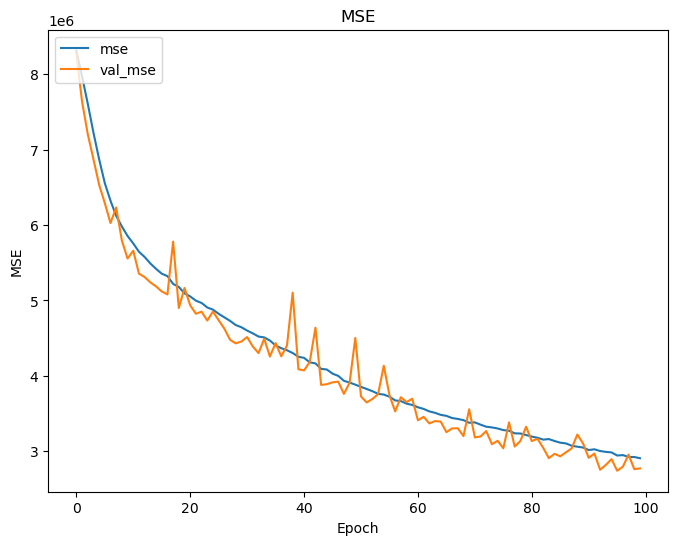

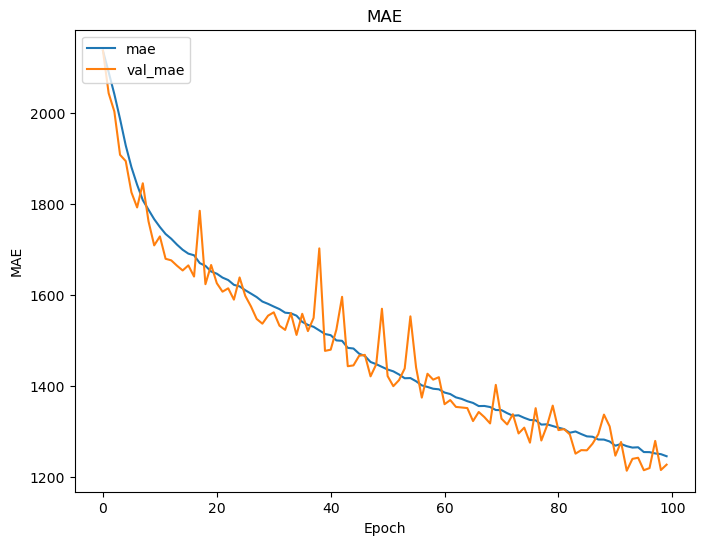

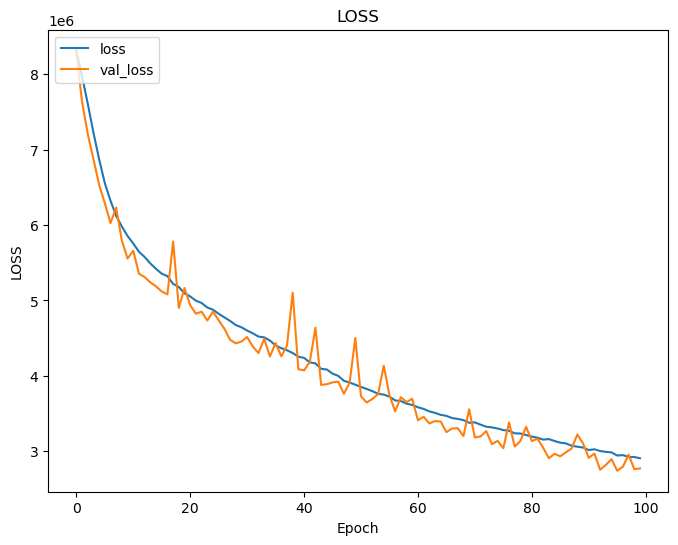

In [106]:
fidle.scrawler.history( history, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='01-history')

In [107]:
results = model.evaluate(X_train, y_train, verbose=1)
print('Test Loss: {}'.format(results))

1311/1311 [==============================] - 2s 2ms/step - loss: 2813197.5000 - mae: 1227.3707 - mse: 2813197.5000
Test Loss: [2813197.5, 1227.3707275390625, 2813197.5]


In [108]:
X_train2 , y_train2 = convert2matrix(train, past, future)
X_train2 = X_train2.reshape(41932, 8)
y_train2 = y_train2.reshape(41932, 3)

def show_result_model(model , col):
    model = model
    yy = model.predict(X_train2)
    #y_pred = yy[:, col]* stds[col+5] + means[col+5]
    #y_target = y_train[:, col] * stds[col+5] + means[col+5]
    y_pred = yy[:, col]
    y_target = y_train2[:, col]
    diff = y_pred - y_target
    print('max deviation: ', np.abs(y_pred - y_target).max())
    print('RMSE: ', np.mean((y_pred - y_target)**2)**0.5)
    print('MAE: ', np.abs(y_pred - y_target).mean())
    
    i = col+1
    load_target = 'PowerConsumption_Zone%i' % i

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 5))

    train.plot(y=load_target, ax=ax1)
    
    ax1.plot(train.index[0:], y_pred)
    ax1.legend(['True {0}'.format(load_target), 'Predictions {0}'.format(load_target)])
    ax2.plot(train.index[-24*5:],y_target[-24*5:])
    index_cor = train.index[0:]
    ax2.plot(index_cor[-24*5:],y_pred[-24*5:])
    #ax2.grid(True)
    ax2.legend(['Zoom True {0}'.format(load_target), 'Zoom Predictions {0}'.format(load_target)])
    plt.show()

1311/1311 [==============================] - 2s 2ms/step
max deviation:  9497.477055625
RMSE:  1510.7492819144527
MAE:  1127.7101392815584


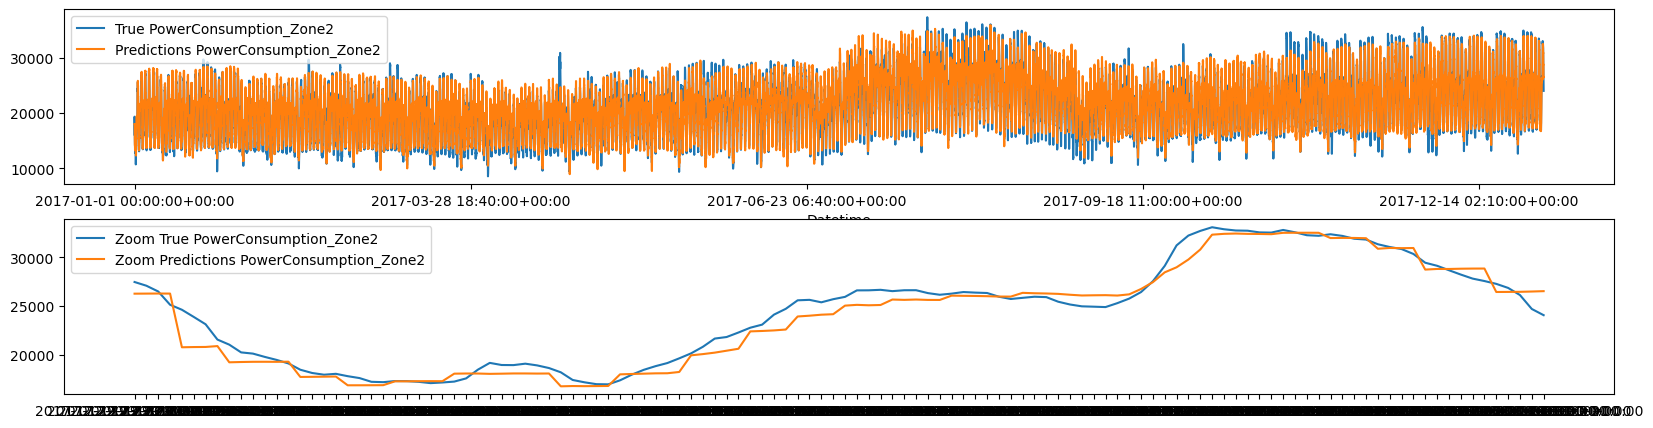

In [111]:
show_result_model(model,1)

In [114]:
X_test1= X_test.reshape(10483,8)

In [116]:
y_pred = model.predict(X_test1)
df = pd.DataFrame(y_pred, columns=['predicted_Zone1','predicted_Zone2','predicted_Zone3'], index=test.index)
df = df.reset_index(drop=False)
df['Datetime'] = Sample['Datetime']
df.to_csv('/kaggle/working/sample.csv', index=False)

328/328 [==============================] - 0s 1ms/step
